In [1]:
from moseq2_detectron_extract.model.model import MoseqDatasetMapper
import os

from moseq2_detectron_extract.model.config import (add_dataset_cfg,
                                                   get_base_config,
                                                   load_config)
from moseq2_detectron_extract.io.annot import (
    default_keypoint_names,
    get_dataset_statistics, read_annotations, register_dataset_metadata,
    register_datasets, replace_data_path_in_annotations, show_dataset_info,
    validate_annotations)


from albumentations.augmentations.transforms import GaussNoise, RandomFog
from albumentations.augmentations.geometric.transforms import Perspective
from moseq2_detectron_extract.model.augmentations import Albumentations, DoughnutWhiteNoiseAugmentation, DoughnutGRFNoiseAugmentation, RandomFieldNoiseAugmentation, ScaleAugmentation, ParticleNoiseAugmentation
from detectron2.data.transforms.augmentation_impl import RandomBrightness, RandomContrast, RandomRotation, ResizeScale,FixedSizeCrop
from detectron2.data.transforms import (Augmentation, BlendTransform,
                                        NoOpTransform, Transform, ResizeTransform, TransformList, CropTransform)
from detectron2.data import build_detection_train_loader
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from detectron2.data import transforms as T
import random
from PIL import Image
from moseq2_detectron_extract.io.image import read_image
import copy


In [2]:
def plot_image(data, ax=None, vmin=None, vmax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    idata = np.squeeze(data['image'].numpy())
    #print(idata.min(), idata.max())
    im = ax.imshow(idata, vmin=vmin, vmax=vmax)
    for bbox in data['instances'].gt_boxes:
        ax.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))

    ax.set_title(os.path.basename(data['file_name']))
    plt.colorbar(im, ax=ax)

def plot_image_series(items, ncols = 3, figsize = None, vmin=None, vmax=None):
    nrows = len(items) // ncols
    if figsize is None:
        figsize = (8 * ncols, 8 * nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    axs = list(itertools.chain(*axs))

    for i, data in enumerate(items):
        #print(data)
        plot_image(data, ax=axs[i], vmin=vmin, vmax=vmax)

    fig.tight_layout()


def plot_orig_vs_augmented(data, vmin=None, vmax=None):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    orig_image = read_image(data["file_name"], scale_factor=data['rescale_intensity'], dtype='uint8')

    data_copy = copy.deepcopy(data)

    im = axs[0].imshow(orig_image[:,:,0], vmin=vmin, vmax=vmax)
    axs[0].set_title("Original")
    plt.colorbar(im, ax=axs[0])

    plot_image(data, ax=axs[1], vmin=vmin, vmax=vmax)
    axs[1].set_title("Augmented")


In [3]:
model_dir = r'C:\Users\thackray\git\moseq2-detectron-extract\notebooks\models\2022-02-19_big_model_5k_imgs\2022-06-13T18-05_15'
annot_file = [
    "C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\project-3-at-2022-06-13-22-03-09402624.json",
    "C:\\Users\\thackray\\moseq-detectron-data\\2022-02-19_sci-dataset-outlier-annotated-keypoints-masks\\project-64-at-2022-02-19-19-06-e5e40b7e.json",
]
replace_data_path = [
    ("/data/local-files/?d=Moseq-SCI-Detectron/images/", "C:\\Users\\thackray\\moseq-detectron-data\\2021-09-15_sci-dataset-big-annotated-keypoints-masks\\images\\"),
    ("/data/upload/", "C:\\Users\\thackray\\moseq-detectron-data\\2022-02-19_sci-dataset-outlier-annotated-keypoints-masks\\images\\"),
]

cfg = load_config(os.path.join(model_dir, "config.yaml"))
cfg.SOLVER.IMS_PER_BATCH = 24
cfg.DATALOADER.NUM_WORKERS = 0


intensity_scale = 1.0

annotations = []
for anot_f in annot_file:
    annot = read_annotations(anot_f, default_keypoint_names, mask_format=cfg.INPUT.MASK_FORMAT, rescale=intensity_scale)
    annotations.extend(annot)

for search, replace in replace_data_path:
    replace_data_path_in_annotations(annotations, search, replace)

validate_annotations(annotations)
#annotations = augment_annotations_with_rotation(annotations)
print('Dataset information:')
show_dataset_info(annotations)
register_datasets(annotations, default_keypoint_names)

Dataset information:


In [13]:
augs = [
    RandomRotation([0, 359], expand=False, sample_style='range'),
    ScaleAugmentation(0.75, 1.2, 250, 250),
    FixedSizeCrop((250, 250), pad=True, pad_value=0),
    RandomBrightness(0.9, 1.1),
    RandomContrast(0.9, 1.1),
    Albumentations(GaussNoise()),
    DoughnutGRFNoiseAugmentation(p=0.5),
    ParticleNoiseAugmentation(p=0.5),
    RandomFieldNoiseAugmentation(p=0.5),
    
]
loader = build_detection_train_loader(cfg, mapper=MoseqDatasetMapper(cfg, is_train=True, augmentations=augs, recompute_boxes=True))

In [14]:
items = list(itertools.islice(loader, 1))[0]

c:\Users\thackray\.conda\envs\moseq-detectron\lib\site-packages\fvcore\transforms\transform.py:724: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in cropped:


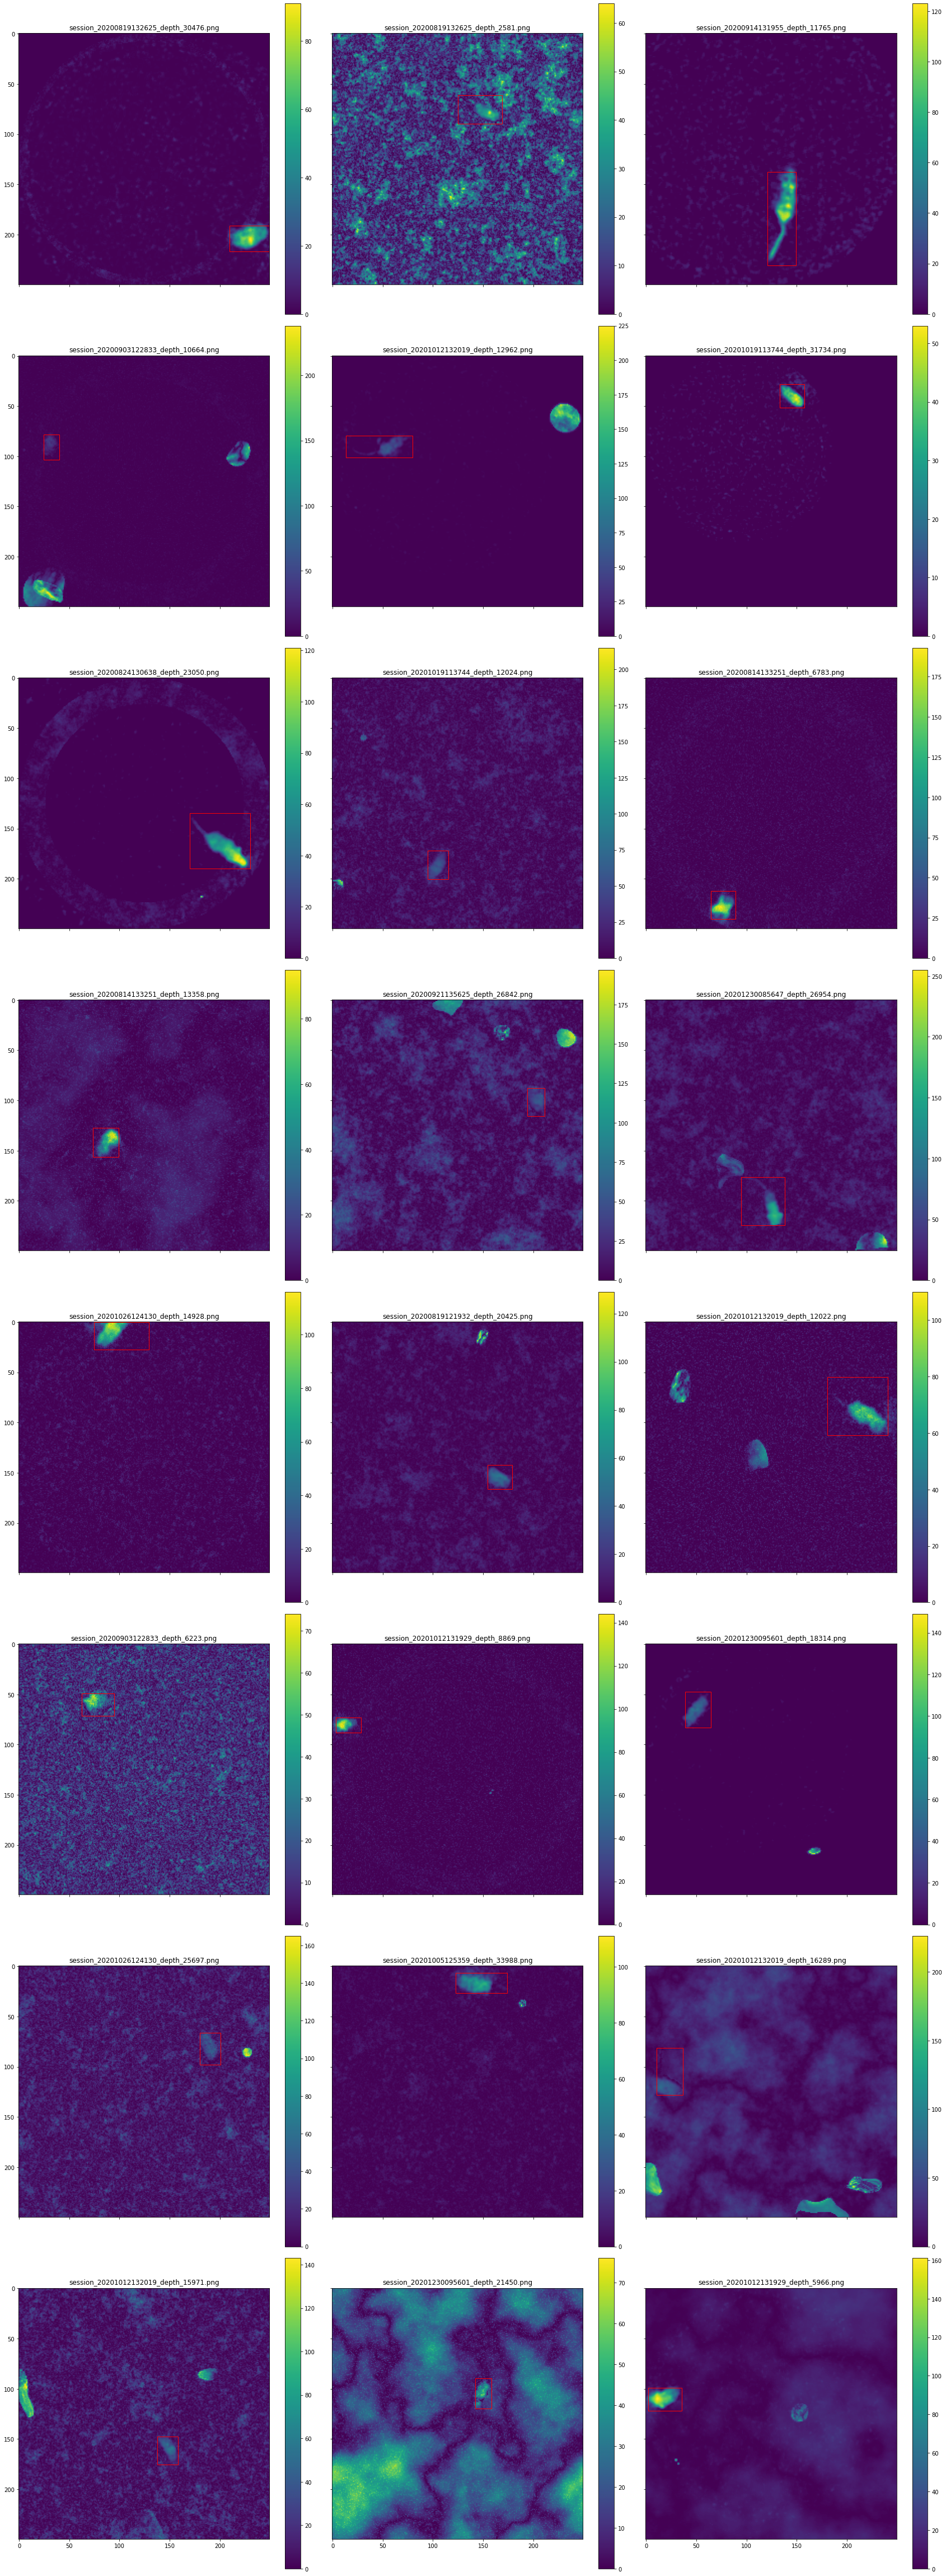

In [15]:
num_images = cfg.SOLVER.IMS_PER_BATCH
vmin = 0
vmax = None

plot_image_series(items, vmin=vmin, vmax=vmax)


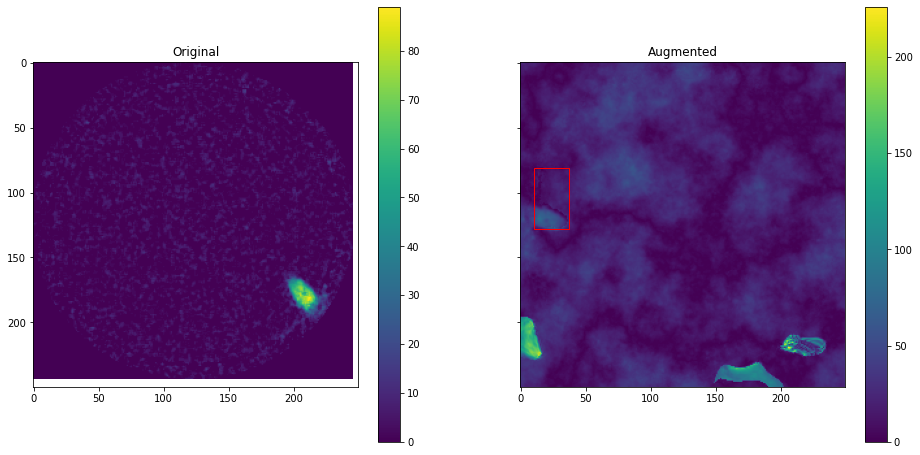

In [16]:
plot_orig_vs_augmented(items[20], vmax=None)